In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Importing necessary Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import tqdm as tqdm
import cv2 as cv
import keras
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D ,GlobalAveragePooling2D ,Flatten , Dense , Dropout , BatchNormalization 
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
tf.keras.applications.VGG16
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

**Importing necessary Libraries**

converting categorical labels to numeric codes

In [2]:
encoder = OneHotEncoder()     #LabelEncoder encode labels with value between 0 and n_classes-1
encoder.fit([[0],[1]])   

OneHotEncoder()

**Loading the data**

Resizing the image based on input dimension required for the model

In [3]:
data = []
paths = []
result = []
for r,d,f in os.walk(r"/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r,file))
for path in paths:
    img = Image.open(path)
    img = img.resize((250,250))
    img = np.array(img)
    if(img.shape == (250,250,3)):
        data.append(img)
        result.append(encoder.transform([[0]]).toarray())

In [4]:
paths = []
for r,d,f in os.walk(r"/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r,file))
for path in paths:
    img = Image.open(path)
    img = img.resize((250,250))
    img = np.array(img)
    if(img.shape == (250,250,3)):
        data.append(img)
        result.append(encoder.transform([[1]]).toarray())

**Count of each category**

In [5]:
result = np.array(result)
result = result.reshape(-1,2)

In [6]:
result.shape

(139, 2)

In [7]:
data = np.array(data)
#data = data.reshape(139, 128, 128, 3)
data.shape

(139, 250, 250, 3)

**Displaying random images**

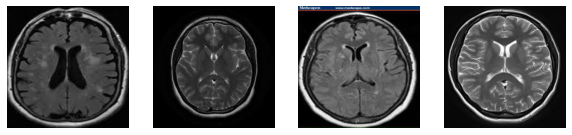

In [8]:
%matplotlib inline
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(data[i], cmap="gray")
    plt.axis('off')
plt.show()

**Splitting data into training and testing data**

In [9]:
x_train , x_test , y_train , y_test = train_test_split(data , result , test_size = 0.1 , shuffle = True , random_state = 10)

In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [11]:
print("x_train Shape : ", x_train.shape) 
print("x_test Shape : ", x_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

x_train Shape :  (125, 250, 250, 3)
x_test Shape :  (14, 250, 250, 3)
y_train Shape:  (125, 2)
y_test Shape:  (14, 2)


**Pre-Trained VGG16 model**

In [12]:
import tensorflow.keras as K

In [13]:
input_v = K.Input(shape=(250,250,3))

In [14]:
modelVGG = VGG16(include_top = False,weights = 'imagenet',input_tensor = input_v)

58900480/58889256 [==============================] - 2s 0us/step


In [15]:
vgg16_output = GlobalAveragePooling2D()(modelVGG.output)

In [16]:
for layer in modelVGG.layers:
    layer.trainable = False

In [17]:
modelresnet = K.applications.ResNet50(include_top=False,weights='imagenet',input_tensor = input_v)

94781440/94765736 [==============================] - 3s 0us/step


In [18]:
resnet50_output = GlobalAveragePooling2D()(modelresnet.output)
for layer in modelresnet.layers:
    layer.trainable = False

In [19]:
from keras.layers import concatenate
combined_layer = concatenate([vgg16_output,resnet50_output])
top_modelf = Dense(4096,activation='relu')(combined_layer)
top_modelf = Dense(1024,activation='relu')(top_modelf)
#top_modelf = Dropout(0.25, name='dropout_1')(top_modelf)
fc1 = Dense(512,activation='relu')(top_modelf)
fc2= Dense(2,activation='softmax')(fc1)
#Model Definition 
merged = Model(inputs = input_v,outputs = fc2)

In [20]:
merged.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [21]:
history = merged.fit(x_train , y_train , epochs = 10 , validation_data = (x_test , y_test), verbose = 1)

Epoch 1/10
4/4 [==============================] - 20s 2s/step - loss: 14.5536 - accuracy: 0.4800 - val_loss: 8.9060 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 1s 163ms/step - loss: 3.4580 - accuracy: 0.5920 - val_loss: 0.5923 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 1s 188ms/step - loss: 0.6954 - accuracy: 0.5920 - val_loss: 0.4419 - val_accuracy: 0.7857
Epoch 4/10
4/4 [==============================] - 1s 163ms/step - loss: 0.4298 - accuracy: 0.8240 - val_loss: 0.2398 - val_accuracy: 0.9286
Epoch 5/10
4/4 [==============================] - 1s 170ms/step - loss: 0.3307 - accuracy: 0.8880 - val_loss: 0.2144 - val_accuracy: 0.9286
Epoch 6/10
4/4 [==============================] - 1s 189ms/step - loss: 0.5083 - accuracy: 0.7840 - val_loss: 0.1616 - val_accuracy: 0.9286
Epoch 7/10
4/4 [==============================] - 1s 190ms/step - loss: 0.4340 - accuracy: 0.8400 - val_loss: 0.2891 - val_accuracy: 0.8571
Epoch 8/10
4/4 [=====

In [22]:
_,acc = merged.evaluate(x_test,y_test)
print("Test accuracy",acc*100)

1/1 [==============================] - 0s 84ms/step - loss: 0.1879 - accuracy: 0.9286
Test accuracy 92.85714030265808


In [23]:
_,acc = merged.evaluate(x_train,y_train)
print("Train accuracy",acc*100)

4/4 [==============================] - 1s 135ms/step - loss: 0.2072 - accuracy: 0.9200
Train accuracy 92.00000166893005


**Summary of the network layers**

**Fitting the Model**

In [24]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

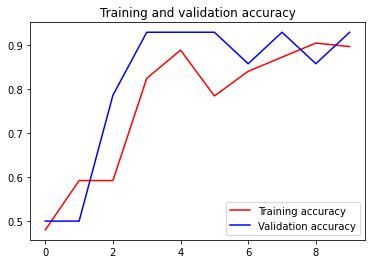

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

**Testing the model**

In [26]:
def names(number):
    if number==0:
        return "It's a TUMOR"
    else:
        return "It's NOT a Tumor"

**Testing the model for a random image**

99.45799112319946% Confidence It's NOT a Tumor


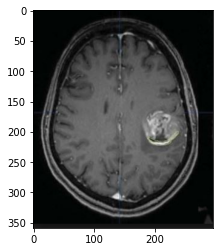

In [27]:
from matplotlib.pyplot import imshow
img = Image.open(r"../input/brain-mri-images-for-brain-tumor-detection/yes/Y19.JPG")
x = np.array(img.resize((250,250)))
x = x.reshape(1,250,250,3)
res = merged.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))